<a href="https://colab.research.google.com/github/noeyhey/HUFS_Untructured-DM/blob/main/UnstructuredDM_0429.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

음성데이터 이해 및 처리 9주차 실습

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 필수 패키지 설치
!pip install librosa noisereduce webrtcvad pydub openai-whisper --quiet

# 라이브러리 불러오기
import os
import requests
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import noisereduce as nr
import webrtcvad
import whisper
import soundfile as sf
import re
from pydub import AudioSegment

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/o

In [ ]:
# 샘플 데이터 다운로드
url = 'https://github.com/Jakobovski/free-spoken-digitdataset/raw/master/recordings/0_jackson_0.wav'
filename = 'sample.wav'

if not os.path.exists(filename):
  r = requests.get(url)
  with open(r'/content/drive/MyDrive/Colab Notebooks/'+filename, 'wb') as f:
    f.write(r.content)

In [ ]:
# 0: 보수적(적은 민감성, 음성구간을 넓게 판단), 3: 공격적()

def apply_vad(filename, aggressiveness=3):
  sound = AudioSegment.from_wav(filename).set_channels(1).set_frame_rate(16000)
  # 오디오를 모노(1채널), 샘플링 레이트 16kHz로 변환 (VAD가 요구하는 형태)

  raw_audio = sound.raw_data
  sample_rate = sound.frame_rate # 1초 동안 몇 번 소리를 측정(샘플링)? -> (헤르츠)

  vad = webrtcvad.Vad(aggressiveness) # VAD 객체 선언

  frame_duration = 30 # ms
  frame_size = int(sample_rate * frame_duration / 1000) * 2 # 16-bit PCM(Pulse Code modulation) 소리를 변환하는 방식
  voiced_frames = b''# 빈 바이너리 데이터에서 시작 (리스트 X)

  for i in range(0, len(raw_audio), frame_size):
    frame = raw_audio[i:i+frame_size]
    if len(frame) < frame_size:
      break
    if vad.is_speech(frame, sample_rate):
      voiced_frames += frame
  voiced_audio = AudioSegment(data=voiced_frames, sample_width=2, frame_rate=16000, channels=1)
  return voiced_audio

filename = '/content/drive/MyDrive/Colab Notebooks/sample.wav'
voiced_segment = apply_vad(filename)
voiced_segment.export('/content/drive/MyDrive/Colab Notebooks/voiced.wav', format='wav')

<_io.BufferedRandom name='/content/drive/MyDrive/Colab Notebooks/voiced.wav'>

In [ ]:
# 노이즈 제거
y, sr = librosa.load(r'/content/drive/MyDrive/Colab Notebooks/'+"voiced.wav", sr=None)
noise_sample = y[:int(0.1 * sr)] # 초반부잡음 추정
denoised = nr.reduce_noise(y=y, y_noise=noise_sample, sr=sr)
sf.write(r'/content/drive/MyDrive/Colab Notebooks/'+"clean.wav", denoised, sr)

# ASR: Whisper로 텍스트 추출
model = whisper.load_model("base") # tiny, base, small, ...
result = model.transcribe(r'/content/drive/MyDrive/Colab Notebooks/'+"clean.wav")
raw_text = result["text"]
print("ASR 인식결과:", raw_text)

# 텍스트 정규화
def normalize_text(text):
  text = text.lower()
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\s+', ' ', text)
  return text.strip()

clean_text = normalize_text(raw_text)
print("정규화된 텍스트:", clean_text)

/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


ASR 인식결과:  Zero.
정규화된 텍스트: zero


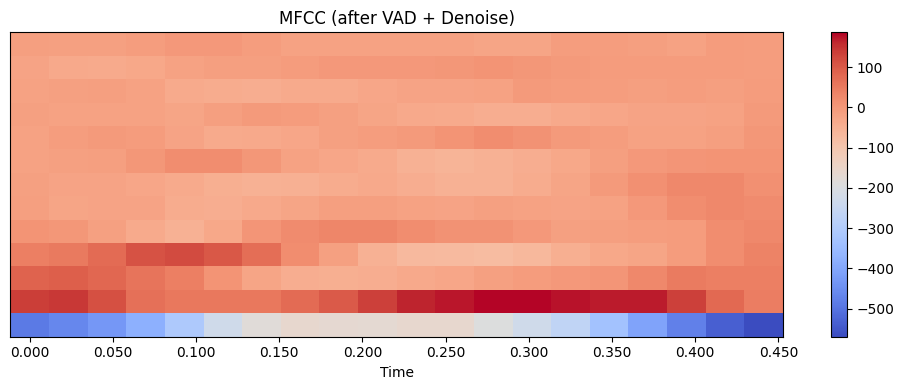

In [ ]:
# MFCC 추출
y_final, sr_final = librosa.load(r'/content/drive/MyDrive/Colab Notebooks/'+"clean.wav", sr=None)
mfccs = librosa.feature.mfcc(y=y_final, sr=sr_final, n_mfcc=13)

# MFCC 시각화
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC (after VAD + Denoise)')
plt.tight_layout()
plt.show()